# Photometric PDFs

This notebook outlines the basics of how to check the quality of photometric PDFs.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz as fz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(1750379)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
survey = pickle.load(open('../data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
types = survey.data['types']  # type flag
templates = survey.data['templates']  # template ID
redshifts = survey.data['redshifts']  # redshift
mags = survey.data['refmags']  # magnitude (reference)
phot_obs = survey.data['phot_obs']  # observed photometry
phot_err = survey.data['phot_err']  # photometry error
phot_true = survey.data['phot_true']  # true photometry
Nobs = len(types)

In [4]:
sel = (phot_obs / phot_err)[:, survey.ref_filter] > 5.  # S/N > 5 cut
Nsel = sel.sum()

Ntrain, Ntest = 60000, 5000
train_sel = np.arange(Nobs)[sel][:Ntrain]  # training set
test_sel = np.arange(Nobs)[sel][Ntrain:Ntrain+Ntest]  # testing set

print('Number of observed galaxies (all):', Nobs)
print('Number of observed galaxies (selected):', Nsel)
print('Number of training galaxies:', Ntrain)
print('Number of testing galaxies:', Ntest)

Number of observed galaxies (all): 200000
Number of observed galaxies (selected): 67951
Number of training galaxies: 60000
Number of testing galaxies: 5000


In [5]:
# initialize datasets
phot_train, phot_test = phot_obs[train_sel], phot_obs[test_sel]
err_train, err_test = phot_err[train_sel], phot_err[test_sel]
mask_train, mask_test = np.ones_like(phot_train), np.ones_like(phot_test)

In [6]:
# initialize asinh magnitudes ("Luptitudes")
flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])
mag, magerr = fz.pdf.luptitude(phot_obs, phot_err, skynoise=fdepths,
                               zeropoints=flux_zeropoint)

# initialize magnitude dictionary 
mdict = fz.pdf.PDFDict(pdf_grid=np.arange(-20., 60., 5e-3), 
                       sigma_grid=np.linspace(0.01, 5., 500))

# initialize redshift dictionary
rdict = fz.pdf.PDFDict(pdf_grid=np.arange(0., 7.+1e-5, 0.01), 
                       sigma_grid=np.linspace(0.005, 2., 500))

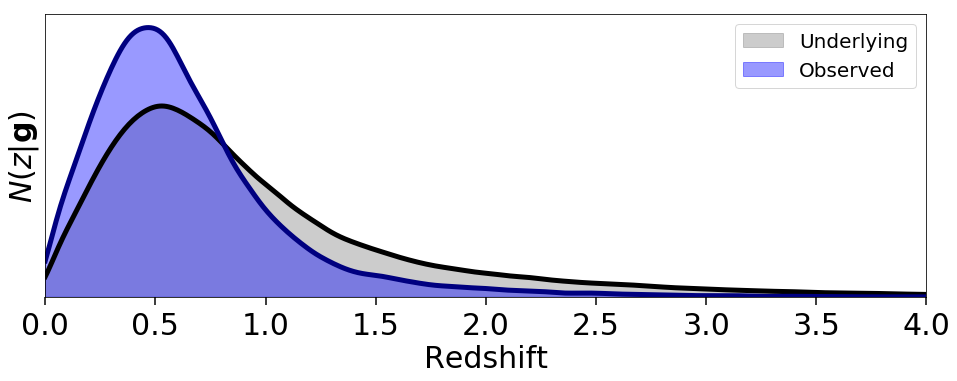

In [7]:
# plotting redshift distribution
plt.figure(figsize=(14, 6))
rsmooth = 0.05

# all
zerr_t = np.ones_like(redshifts) * rsmooth
z_pdf = fz.pdf.gauss_kde_dict(rdict, y=redshifts,
                              y_std=zerr_t)
plt.plot(rdict.grid, z_pdf / z_pdf.sum(), lw=5, color='black')
plt.fill_between(rdict.grid, z_pdf / z_pdf.sum(), color='gray',
                 alpha=0.4, label='Underlying')

# selected
zsel_pdf = fz.pdf.gauss_kde_dict(rdict, y=redshifts[sel],
                                 y_std=zerr_t[sel])
plt.plot(rdict.grid, zsel_pdf / zsel_pdf.sum(), lw=5, color='navy')
plt.fill_between(rdict.grid, zsel_pdf / zsel_pdf.sum(), 
                 color='blue', alpha=0.4, label='Observed')

# prettify
plt.xlim([0, 4])
plt.ylim([0, None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

## Fits

As before, we will take advantage of the `BruteForce` object available through `frankenz`'s `fitting` module to fit these objects.

In [8]:
from frankenz.fitting import BruteForce

train_BF = BruteForce(phot_train, err_train, mask_train)  # training data
pdfs_train, gof = train_BF.fit_predict(phot_test, err_test, mask_test,
                                       redshifts[train_sel], 
                                       np.zeros_like(train_sel),  # no added smoothing
                                       label_dict=rdict,
                                       return_gof=True, save_fits=False)
lmap, levid = gof

Generating PDF 5000/5000


# Population Comparison

The simplest comparison (which we used in the previous notebooks) is to compare the population distribution (via the stacked PDF) to the observed distribution. This is shown below.

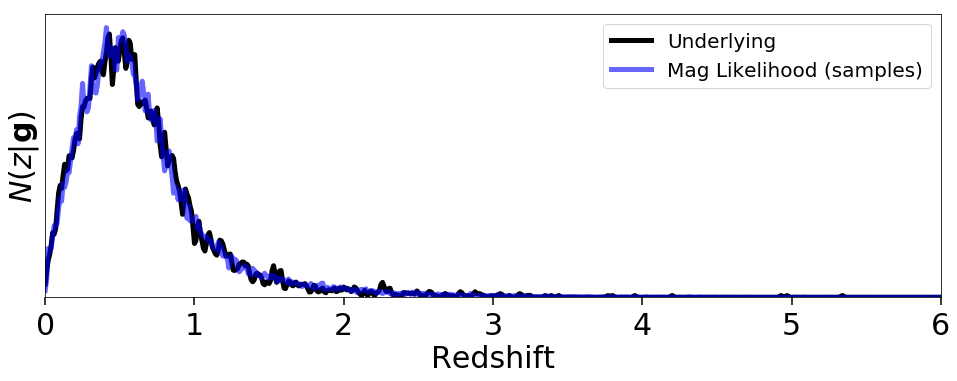

In [9]:
rsmooth = 0.01

# true distribution
zpdf0 = fz.pdf.gauss_kde_dict(rdict, y=redshifts[test_sel],
                              y_std=np.ones_like(test_sel) * rsmooth)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_train.sum(axis=0), 
         lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (samples)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

While our distributions agree, this plot is not actually that useful for diagnosing issues outside of the most obvious disagreements. For that, we will need to examine our predictions for individual objects.

# Point Estimates

Often, it is useful to summarize the PDF with one or more **summary statistics**. These can be helpful to get a broad picture of what's going on before examining our PDFs directly. `frankenz` implements a `pdfs_summarize` function that converts a set of PDFs into a variety of summary statistics based on those used in the [HSC photo-z data release](http://adsabs.harvard.edu/abs/2018PASJ...70S...9T).

In [10]:
# generate point estimates and summary statistics
zmeans, zmeds, zmodes, zbests, zcis, zmc = fz.pdf.pdfs_summarize(pdfs_train, rdict.grid)

Let's now compare our point estimates to the true underlying redshifts.

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


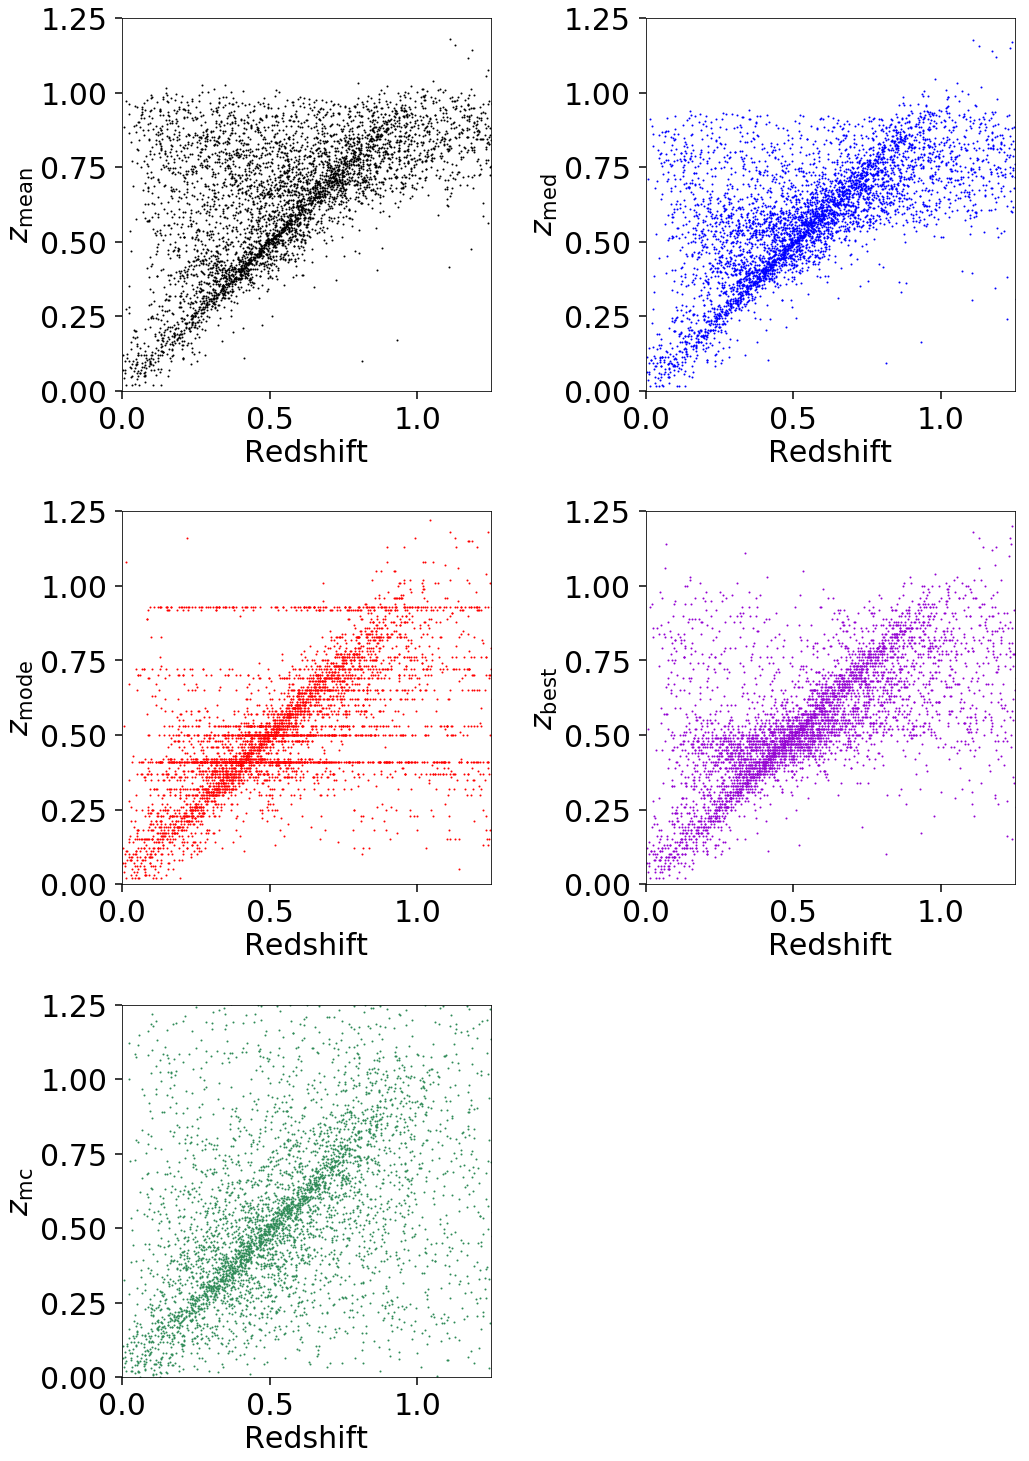

In [11]:
plt.figure(figsize=(15, 21))
plt.subplot(3, 2, 1)
plt.plot(redshifts[test_sel], zmeans[0], 'o', 
         ms=1, color='black')
plt.ylabel(r'$z_{\rm mean}$')
plt.subplot(3, 2, 2)
plt.plot(redshifts[test_sel], zmeds[0], 'o', 
         ms=1, color='blue')
plt.ylabel(r'$z_{\rm med}$')
plt.subplot(3, 2, 3)
plt.plot(redshifts[test_sel], zmodes[0], 'o', 
         ms=1, color='red')
plt.ylabel(r'$z_{\rm mode}$')
plt.subplot(3, 2, 4)
plt.plot(redshifts[test_sel], zbests[0], 'o', 
         ms=1, color='darkviolet')
plt.ylabel(r'$z_{\rm best}$')
plt.subplot(3, 2, 5)
plt.plot(redshifts[test_sel], zmc, 'o', 
         ms=1, color='seagreen')
plt.ylabel(r'$z_{\rm mc}$')
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.xlim([0, 1.25])
    plt.ylim([0., 1.25])
    plt.xlabel('Redshift')
    plt.tight_layout()

We see that the "best" point estimate indeed seems to be the most robust, and that our PDFs appear to have several "attractor solutions" that show up most clearly in the mode, but don't really show up when simulating draws from the PDF. These are causing issues with the mean and median estimators, which appear to be trying to compromise between solutions. Our Monte Carlo estimates probe the general distribution and don't show evidence of a ceiling or any attractor solutions given the small number of samples.

In addition, our point estimates also come with quality metrics. We'll plot some of these below to get a sense of what our PDFs "look like"

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


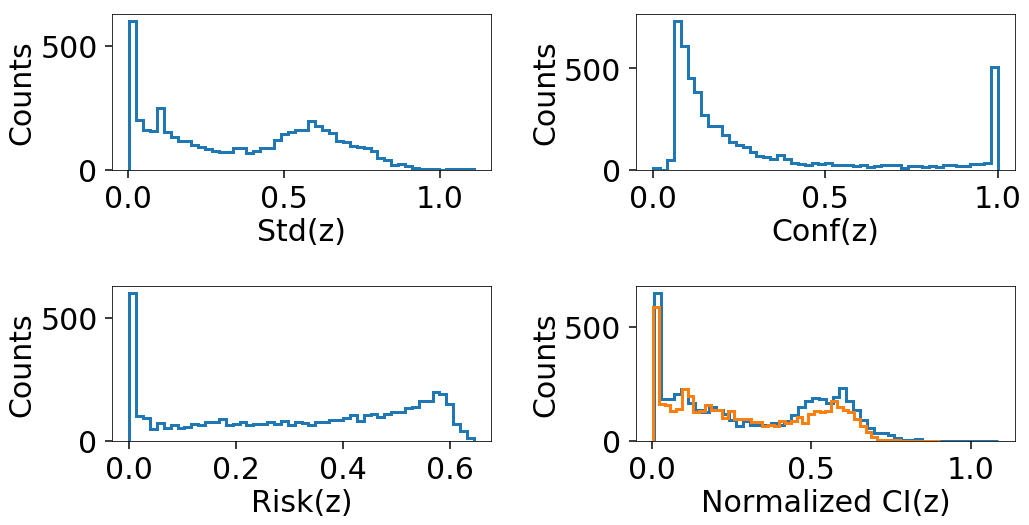

In [12]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.hist(zbests[1], 50, 
         lw=3, histtype='step')
plt.xlabel('Std(z)')
plt.subplot(2, 2, 2)
plt.hist(zbests[2], 50, 
         lw=3, histtype='step')
plt.xlabel('Conf(z)')
plt.subplot(2, 2, 3)
plt.hist(zbests[3], 50, 
         lw=3, histtype='step')
plt.xlabel('Risk(z)')
plt.subplot(2, 2, 4)
plt.hist((zcis[-1] - zcis[0]) / 4., 50, 
         lw=3, histtype='step')
plt.hist((zcis[-2] - zcis[1]) / 2., 50, 
         lw=3, histtype='step')
plt.xlabel('Normalized CI(z)')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.ylabel('Counts')
    plt.tight_layout()

We see that our PDFs are roughly bimodal: there are a series of PDFs which are very well defined with narrow PDFs, and a set which are much broader and likely bimodal (given the "hump" seen in the upper-left/lower-right panels).

# Individual PDF Accuracy

In addition to the point estimates above, it's often useful to just visually inspect our results. `frankenz.plotting` contains a variety of useful plotting utilities for seeing how we've done. The most straightforward is plotting the 2-D stacked PDFs as a function of some input. This can be done using the `input_vs_pdf` function.

Plotting our $P(z|g)$'s vs the input (true) redshifts shows our PDFs actually look quite reasonable even though the point estimates are all over the place.

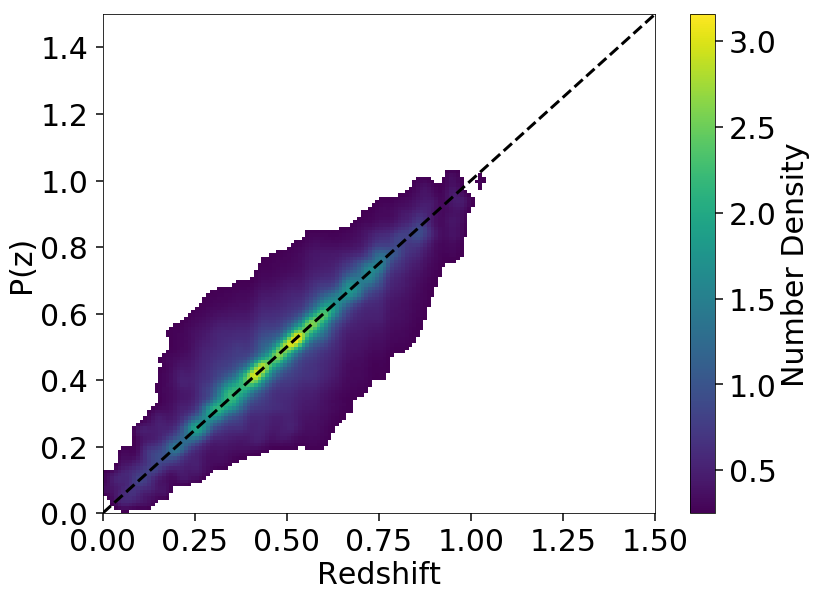

In [13]:
from frankenz import plotting as fzplot

# plot redshift vs PDFs
plt.figure(figsize=(12, 9))
hh = fzplot.input_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         rdict, pdfs_train, rdict.grid,
                         plot_thresh=0.25, smooth=1.5)
plt.plot([0, 100], [0, 100], 'k--', lw=3)  # 1:1 relation
plt.xlabel('Redshift')
plt.ylabel('P(z)')
plt.xlim([0., 1.5])
plt.ylim([0., 1.5])
plt.tight_layout()

We can also examine how they evolve as a function of redshift.

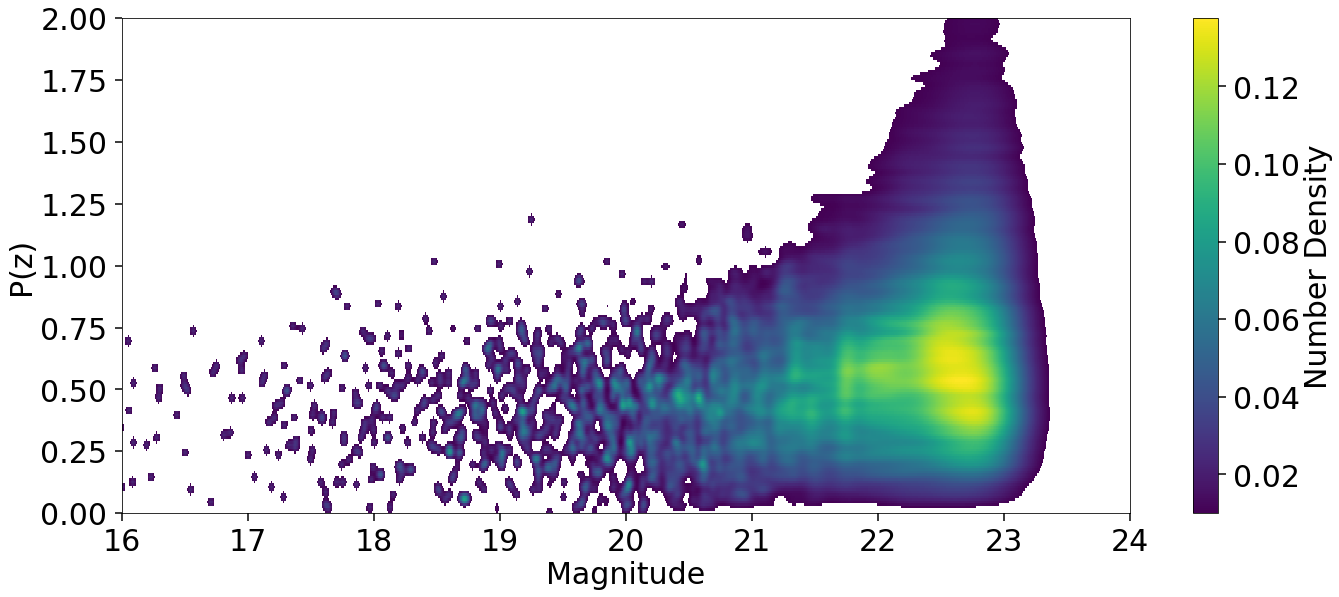

In [16]:
# plot r-band magnitude vs PDFs
plt.figure(figsize=(20, 9))
hh = fzplot.input_vs_pdf(mag[test_sel, survey.ref_filter], 
                         magerr[test_sel, survey.ref_filter], 
                         mdict, pdfs_train, rdict.grid,
                         plot_thresh=0.01, smooth=(4., 1.5))
plt.xlabel('Magnitude')
plt.ylabel('P(z)')
plt.xlim([16., 24.])
plt.ylim([0., 2.])
plt.tight_layout()

Rather than just seeing how our PDFs behave as a function of various inputs, we might instead be interested in how our **centered** PDFs $P(z_g - \Delta z|g)$ behave. We can plot those results using the `input_vs_dpdf` function. Note that this allows us to pass in a custom function to compute the effective "dispersion", which is useful for our purposes because we are most often interested in $\Delta z / (1+z)$ instead of $\Delta z$.

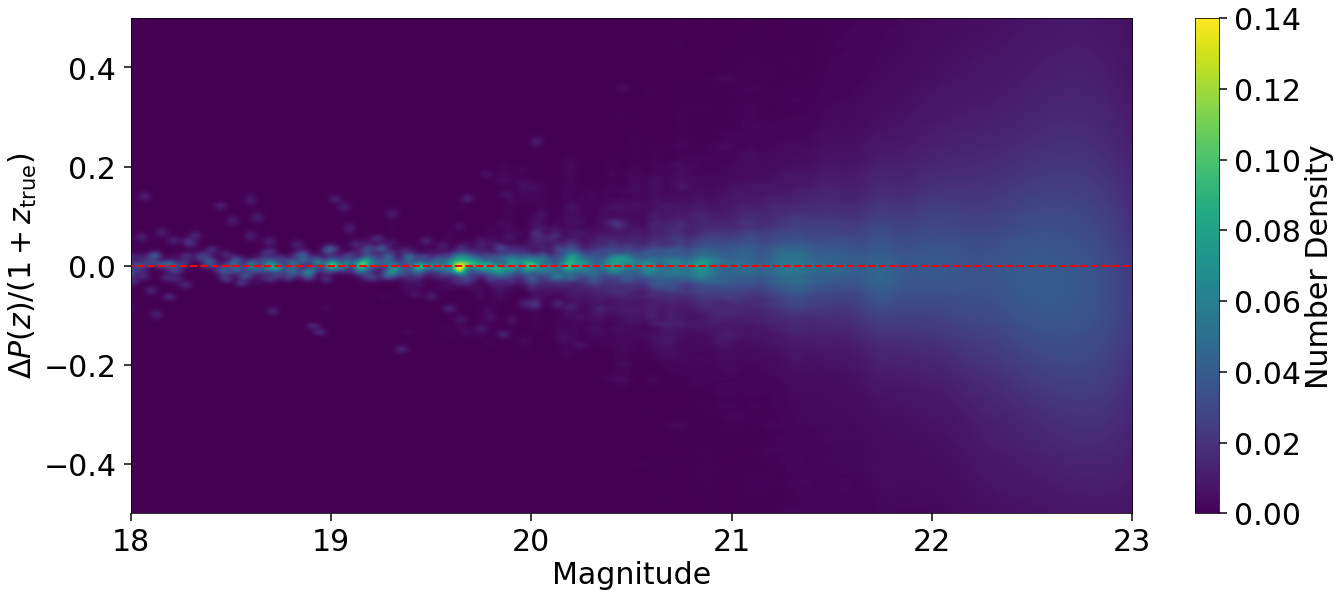

In [18]:
# define our dispersion function
def deltazp(zgrid, z):
    return (zgrid - z) / (1. + z)

# plot r-band magnitude vs PDFs
dgrid = np.linspace(-1, 1, 1000)
plt.figure(figsize=(20, 9))
hh = fzplot.input_vs_dpdf(mag[test_sel, survey.ref_filter], 
                          magerr[test_sel, survey.ref_filter], 
                          mdict, pdfs_train, rdict.grid,
                          redshifts[test_sel], dgrid,
                          disp_func=deltazp,
                          plot_thresh=0, smooth=(4., 2.))
plt.plot([0, 100], [0, 0], 'r--', lw=2)
plt.xlabel('Magnitude')
plt.ylabel(r'$\Delta P(z)/(1+z_{\rm true})$')
plt.xlim([18., 23.])
plt.ylim([-0.5, 0.5])
plt.tight_layout()

The resulting 2-D stacked array can also be used to compute other relevant quantities such as the mean/median bias and associated spread.

In [19]:
# compute bias and scatter
dpdf = np.nansum(hh, axis=0) / np.nansum(hh)
dcdf = dpdf.cumsum()
print('Mean bias:', np.dot(dgrid, dpdf))
print('Median bias:', np.interp(0.5, dcdf, dgrid))
print('68% CI:', np.interp([0.16, 0.84], dcdf, dgrid))
print('95% CI:', np.interp([0.025, 0.975], dcdf, dgrid))

Mean bias: 0.007229800594350758
Median bias: -0.0033041222600514687
68% CI: [-0.1948623   0.19380511]
95% CI: [-0.55635405  0.69992246]


We can also check the overall **coverage** of our PDFs to see how well they are actually able to capture the underlying uncertainties. We can quantify this using the distribution of empirical CDF (ECDF) values

$$ \hat{u}_g \equiv \int_0^{z_g} P(z|g) dz $$

given the true redshift $z_g$ and the associated PDF $P(z|g)$. For truly representative PDFs (at least in the frequentist sense), we would expect $\hat{u}_g \sim \textrm{Unif}(0,1)$ to be distributed uniformly from 0 to 1.

`frankenz` can make two versions of this plot: one showing the binned PDF of $\lbrace \hat{u}_g \rbrace$ (`cdf_vs_epdf`) and one showing the sorted CDF of $\lbrace \hat{u}_g \rbrace$ (`cdf_vs_ecdf`).

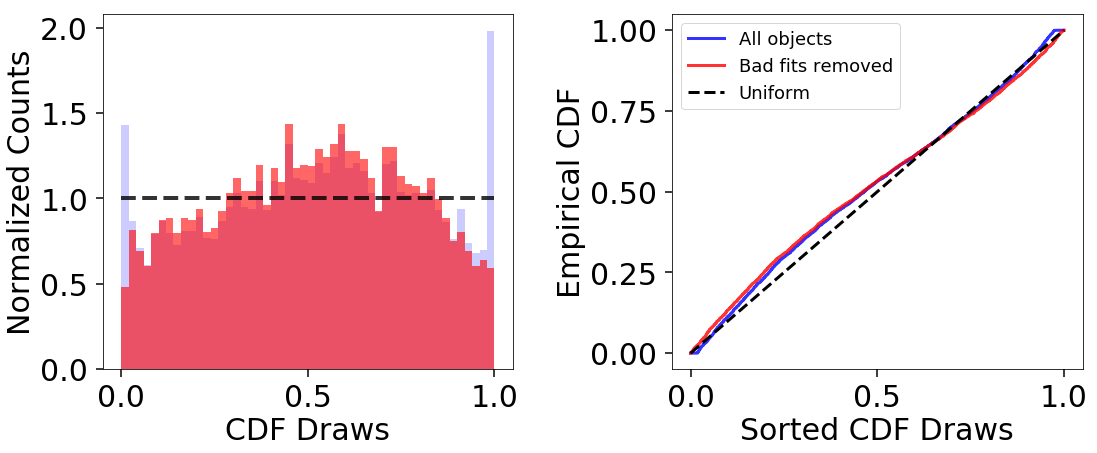

In [20]:
fclean = 0.10  # fraction of fits to remove

csel = ((levid > np.sort(levid)[int(0.10 * Ntest)]) &
        (lmap > np.sort(lmap)[int(0.10 * Ntest)])) # flag bad fits

# plot CDF results
plt.figure(figsize=(16, 7))
plt.subplot(121)
fzplot.cdf_vs_epdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, 
                   plot_kwargs={'color': 'blue', 'alpha': 0.2})
fzplot.cdf_vs_epdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel,
                   plot_kwargs={'color': 'red', 'alpha': 0.6})
plt.hlines(1., 0., 1., colors='black', lw=4, alpha=0.8,
           linestyles='--')  # best-case result
plt.tight_layout()
plt.subplot(122)
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, 
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.tight_layout()

While our sample-based redshift PDFs appear slightly overly broad (with more values concentrated around the center) and biased (with values of $\hat{u}_g$ skewing above 0.5), on the whole they agree reasonably well with the theoretical expectation. We can get a better sense of what's causing this by checking how this changes as a function of magnitude.

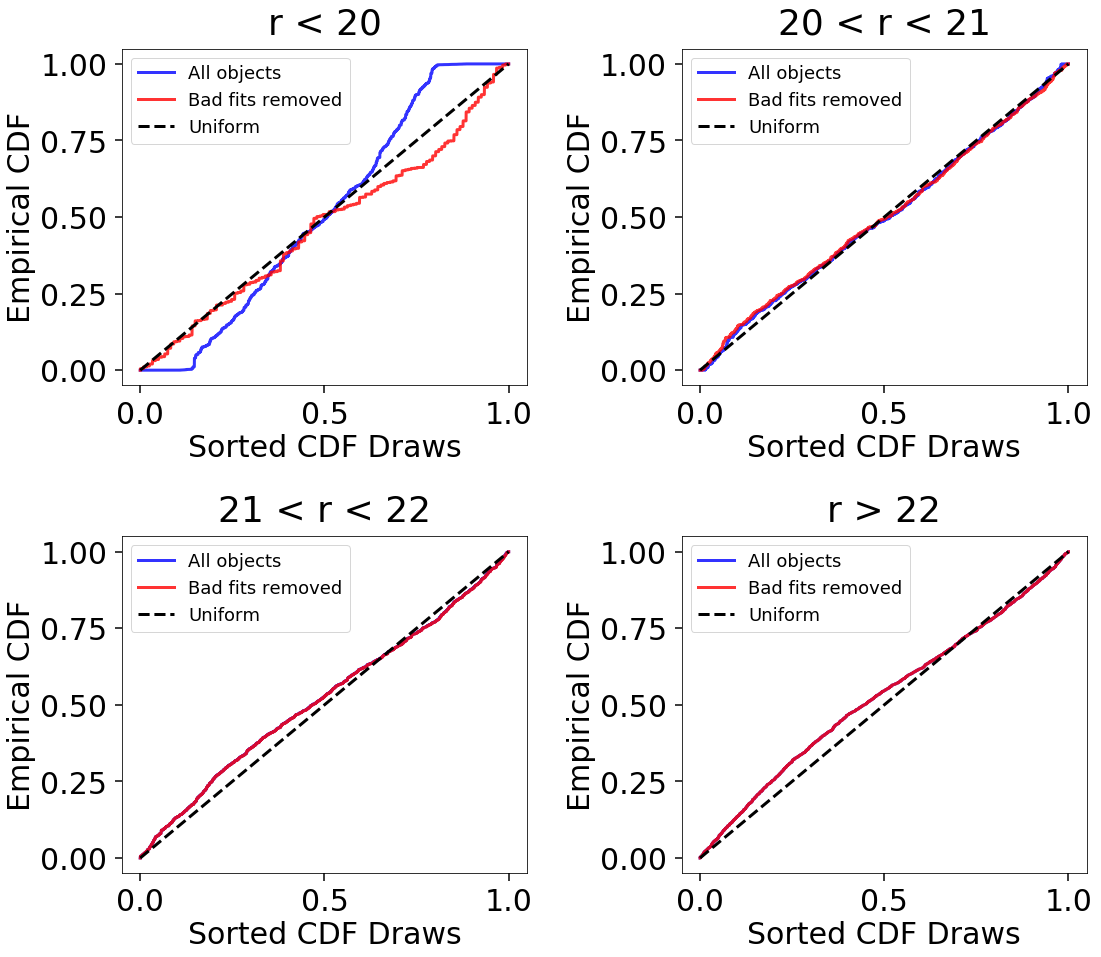

In [21]:
# plot results
plt.figure(figsize=(16, 14))
plt.subplot(221)
msel = mag[test_sel, survey.ref_filter] < 20
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=msel,
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel*msel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('r < 20')
plt.tight_layout()
plt.subplot(222)
msel = ((mag[test_sel, survey.ref_filter] > 20) & 
        (mag[test_sel, survey.ref_filter] < 21))
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=msel,
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel*msel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('20 < r < 21')
plt.tight_layout()
plt.subplot(223)
msel = ((mag[test_sel, survey.ref_filter] > 21) & 
        (mag[test_sel, survey.ref_filter] < 22))
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=msel,
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel*msel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('21 < r < 22')
plt.tight_layout()
plt.subplot(224)
msel = (mag[test_sel, survey.ref_filter] > 22)
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=msel,
                   plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                   pdfs_train, rdict.grid, weights=csel*msel,
                   plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('r > 22')
plt.tight_layout()

Our clipping procedure seems to mostly remove brighter objects, which makes sense because they are sparsely sampled relative to their respective errors. We also see that most of the PDF "excess" appears to come in at fainter magnitudes; we perform best around $20 < r < 21$.